In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

In [2]:
fh = open('research_fishes/summary.txt', 'r')
label_index = []
for index,line in enumerate(fh):
    label_index.append((line.split()[0],index))
label_indexs = dict(label_index)
label_indexs

{'fish_cod': 0,
 'fish_commondab': 1,
 'fish_greygurnard': 2,
 'fish_haddock': 3,
 'fish_hake': 4,
 'fish_horsemackerel': 5,
 'fish_longroughdab': 6,
 'fish_mackerel': 7,
 'fish_norwaypout': 8,
 'fish_plaice': 9,
 'fish_redgurnard': 10,
 'fish_saithe': 11,
 'fish_whiting': 12}

In [3]:
def generate_imgs_file(dir):
    import glob
    path_dic = []
    for index,value in enumerate(label_indexs.keys()):
        #print(type(i))
        paths = glob.glob(dir + "/*/"+ value +"/*.png")

        for path in paths:
            path_dic.append([path,index])
    
    path_dic = pd.DataFrame(path_dic,columns = ['path','label'])
    return path_dic

In [4]:
path_dic = generate_imgs_file('commercial_fishes')
print(path_dic.shape)
path_dic.head()

(10057, 2)


,path,label
0,commercial_fishes/fold_127/fish_cod/c3cc47ed-0...,0
1,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
2,commercial_fishes/fold_127/fish_cod/0158dd29-8...,0
3,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
4,commercial_fishes/fold_117/fish_cod/b19fca17-7...,0


In [5]:
path_dic2 = generate_imgs_file('research_fishes')
print(path_dic2.shape)
path_dic2.head()

(9620, 2)


,path,label
0,research_fishes/fold_011/fish_cod/66488f15-aff...,0
1,research_fishes/fold_011/fish_cod/1fd0d098-70e...,0
2,research_fishes/fold_011/fish_cod/0fbd916b-ea0...,0
3,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0
4,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0


In [6]:
train_transform = A.Compose(
    [
        A.Affine(translate_px={"x":(-2,2),"y":(-2,2)}, scale = (0.75,1.333), rotate = 180, p = 0.5),
        A.CoarseDropout(max_holes=1, max_height=90, max_width=90, min_holes=1,fill_value=64, p = 0.5),
        A.GaussNoise(var_limit = (10,100), p = 0.5),
        A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4,p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensorV2()
    ],
)
val_transform = A.Compose(
    [
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ],
)

In [7]:
class MyDataset(Dataset): 
    def __init__(self, path_dic, transform=None):

        self.imgs = list(path_dic.to_records(index=False))
        self.transform = transform
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return img,label
    
    def __len__(self):
        return len(self.imgs)

In [9]:
# val_sour_size = 2000
# num_sour_train = len(path_dic)
# sour_indices = list(range(num_sour_train))
# #split_ratio = 0.8
# #split = int(np.floor(train_size * num_train))
# np.random.shuffle(sour_indices)
# train_sour_idx, valid_sour_idx = sour_indices[val_sour_size:], sour_indices[:val_sour_size]
# train_sour_idx = np.load('train_sour_idx.npy')
# valid_sour_idx = np.load('valid_sour_idx.npy')

train_sour_idx = np.load('train_targ_idx.npy')
valid_sour_idx = np.load('valid_targ_idx.npy')

In [10]:
train_dataset = MyDataset(path_dic, transform = train_transform)
train_dataset2 = MyDataset(path_dic, transform = val_transform)
val_dataset = MyDataset(path_dic2, transform = val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


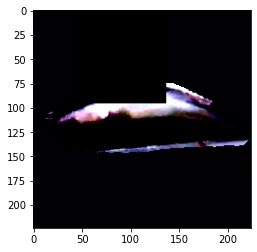

In [11]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[14][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


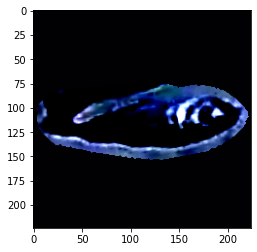

In [12]:
plt.imshow(val_dataset[13][0].permute(1, 2, 0))

In [13]:
train_dataset = Subset(train_dataset, indices=train_sour_idx)
train_dataset2 = Subset(train_dataset2, indices=valid_sour_idx)

In [14]:
def getSampler(labels):
    class_sample_count = np.unique(labels, return_counts=True)[1]
    class_weights = 1./torch.tensor(class_sample_count, dtype=torch.float) 
    class_weights_all = class_weights[labels]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )
    return sampler

In [15]:
sour_train_labels = []
for train_index in train_dataset.indices:
    sour_train_labels.append(train_dataset.dataset.imgs[train_index][1])
sour_train_labels = torch.tensor(sour_train_labels)
sour_sampler = getSampler(sour_train_labels)

In [16]:
sour_train_dl = DataLoader(train_dataset, shuffle=False, batch_size=80, sampler=sour_sampler, num_workers = 4, pin_memory = True)
sour_val_dl = DataLoader(train_dataset2, batch_size=64, num_workers = 4, pin_memory = True)
targ_train_dl = DataLoader(val_dataset, batch_size=64, num_workers = 4, pin_memory = True)

In [17]:
student = torchvision.models.resnet152(pretrained=True)
student.fc = nn.Sequential(
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024,13)
)

In [18]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)
    

In [19]:
device = get_default_device()
device

device(type='cuda')

In [24]:
student = to_device(student, device)

In [25]:
sour_train_dl = DeviceDataLoader(sour_train_dl, device)
targ_train_dl = DeviceDataLoader(targ_train_dl, device)
sour_val_dl = DeviceDataLoader(sour_val_dl, device)

In [26]:
log_file = "log/trainTargetOnly_logfile_04"
def logfile(text):
    print(text)
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(text + '\n')
            f.flush()
            f.close()
logfile("resnet 152 pretrain learning rate 10-5, 4 data arugementa CutOut 90*90")

resnet 152 pretrain learning rate 10-5, 4 data arugementa CutOut 90*90


In [27]:
@torch.no_grad()
def train_pred(X_sup):
    student.eval()
    #return F.softmax(student(X_sup), dim=1).detach().cpu().numpy()
    return student(X_sup)

@torch.no_grad()
def f_eval_src(val_dl,num):

    stu_num = 0
    for X_sup, y_sup in val_dl:

        y_pred_prob_stu = train_pred(X_sup)
        #y_pred_stu = np.argmax(y_pred_prob_stu, axis=1)
        _, y_pred_stu = torch.max(y_pred_prob_stu, dim=1)
        
        stu_num += torch.tensor(torch.sum(y_pred_stu != y_sup).item())
        #float((y_pred_stu != y_sup.cpu().numpy()).sum())
    return stu_num/num

In [28]:
epochs = 101
opt_func = torch.optim.Adam
lr = 0.00001

optimizer = opt_func(student.parameters(),lr)

import time

loss_his1 = []

log=[]
log1=[]

for epoch in range(epochs):

    t1 = time.time()
    
    student.train()
    train_losses = []
    conf_mask_counts = 0
    
    for batch in sour_train_dl:
        
        X_src, y_src = batch
        src_logits_out = student(X_src)
        loss = F.cross_entropy(src_logits_out, y_src)
        
        train_losses.append(loss)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    log.append(f_eval_src(targ_train_dl,len(val_dataset)))
    log1.append(f_eval_src(sour_val_dl,len(train_dataset2)))

    loss_his1.append(torch.stack(train_losses).mean().item())
    
    t2 = time.time()
                                                 
    logfile('Epoch {} took {:.2f}s: TRAIN clf loss={:.6f},'
        'source dataset student ERR={:.6%}, target dataset student ERR={:.6%},'.format(
         epoch, t2 - t1, loss_his1[epoch], log1[epoch], log[epoch]))                                             
    
    if epoch%20 == 0 and epoch != 0:
        model_name = "modelParameter/TrainTargetOnly04/TrainTargetOnly04_epoch" + str(epoch)
        torch.save(student.state_dict(), model_name)

Epoch 0 took 159.66s: TRAIN clf loss=2.431443,source dataset student ERR=85.350001%, target dataset student ERR=76.548856%,
Epoch 1 took 129.60s: TRAIN clf loss=1.597366,source dataset student ERR=64.050001%, target dataset student ERR=56.330562%,
Epoch 2 took 125.27s: TRAIN clf loss=0.978871,source dataset student ERR=50.449997%, target dataset student ERR=55.218297%,
Epoch 3 took 128.40s: TRAIN clf loss=0.734106,source dataset student ERR=34.950000%, target dataset student ERR=47.692308%,
Epoch 4 took 131.50s: TRAIN clf loss=0.593250,source dataset student ERR=33.649999%, target dataset student ERR=44.844076%,
Epoch 5 took 130.06s: TRAIN clf loss=0.531110,source dataset student ERR=31.150001%, target dataset student ERR=41.600832%,
Epoch 6 took 130.14s: TRAIN clf loss=0.475202,source dataset student ERR=29.949999%, target dataset student ERR=41.465697%,
Epoch 7 took 128.53s: TRAIN clf loss=0.419193,source dataset student ERR=23.100001%, target dataset student ERR=39.459458%,
Epoch 8 